In [1]:
#uncomment all lines below in this cell to replicate my installation on colab

!pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes psaw pyarrow
!apt-get install libproj-dev proj-data proj-bin  
!apt-get install libgeos-dev  
!pip install cython  
!pip install cartopy 
!brew install proj geos
!pip3 uninstall shapely
!pip3 install --upgrade cython numpy pyshp six
!pip3 install shapely --no-binary shapely
!pip3 install git+https://github.com/SciTools/cartopy.git --no-binary cartopy

     |████████████████████████████████| 14.7MB 14.6MB/s 
     |████████████████████████████████| 931kB 21.6MB/s 
     |████████████████████████████████| 1.6MB 18.8MB/s 
     |████████████████████████████████| 235kB 25.9MB/s 
     |████████████████████████████████| 10.9MB 18.6MB/s 
     |████████████████████████████████| 552kB 16.5MB/s 
  Created wheel for qeds: filename=qeds-0.6.2-cp36-none-any.whl size=27820 sha256=a0f9ed114a269e622f7a51c2909907e573233e6f5231fb7de02c0ccd0cd0311d
  Stored in directory: /root/.cache/pip/wheels/b7/0b/74/c09109813c2b6116a2d4f2833c354b24163672f846a50fc7b4
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=5eb009b694509b66eb97aaaa24beecf3670f3b48d99fcabfda84ed38d8c78455
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=07a6e90fb619775f00b72db9d4eb4f0c3c0e4e52c13b466f95908d194

     |████████████████████████████████| 358kB 3.4MB/s 
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for shapely ... done
  Cloning https://github.com/SciTools/cartopy.git to /tmp/pip-req-build-xx9l8fqu
  Running command git clone -q https://github.com/SciTools/cartopy.git /tmp/pip-req-build-xx9l8fqu
Skipping wheel build for Cartopy, due to binaries being disabled for it.
  Found existing installation: Cartopy 0.18.0
    Uninstalling Cartopy-0.18.0:
      Successfully uninstalled Cartopy-0.18.0
    Running setup.py install for Cartopy ... done


In [0]:
import pandas as pd 
import os
import IPython

import json
with open("to_from_data.json", "r") as read_file:
    rankings = json.load(read_file)
data = pd.DataFrame(rankings)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import qeds
qeds.themes.mpl_style();

import cartopy.crs as ccrs #cartopy documentation: https://scitools.org.uk/cartopy/docs/latest/
import cartopy.feature as cfeature

#import geopandas as gpd
#from shapely.geometry import Point

In [0]:
inst_data = pd.read_json("to_from_data.json") #set directory as necessary

In [0]:
inst_data["startdate"] = pd.to_datetime(inst_data["startdate"]) #convert object to datetime

In [7]:
inst_data.name.unique().shape #note 33 unique categories, names

(33,)

In [8]:
inst_data.description.unique() #note 10 unique recruiter_types, descriptions

array(['Academic organization (economics department)',
       'Private (non-profit) business or organization',
       'Academic organization (agricultural/resource economics department)',
       'Academic organization (business school)',
       'Academic organization (other than econ, business, or ag econ)',
       'Government agency or commission', 'Other type of organization',
       'Private (for profit) business or organization',
       'Human Resources department of educational or non-profit institution',
       'Advertising agency or executive recruiter'], dtype=object)

In [9]:
import nltk
nltk.download("punkt")

def desc_reviser(string):
    string = string.lower()
    tokens = [i for i in nltk.tokenize.word_tokenize(string)]
    return(tokens)

#desc_reviser(inst_data.description[6])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
desc_tokens = [desc_reviser(i) for i in inst_data.description]
inst_data["desc_tokens"] = desc_tokens

In [11]:
inst_data["revised_description"] = 0

for i in inst_data.index:
    if "academic" in inst_data.desc_tokens[i]:
        inst_data.revised_description[i] = inst_data.description[i]
        
    elif "government" in inst_data.desc_tokens[i]:
        inst_data.revised_description[i] = inst_data.description[i]
        
    elif "private" or "other" in inst_data.desc_tokens[i]:
        inst_data.revised_description[i] = "Private business or organization; Other type of organization"
        
    else: inst_data["revised_description"][i] = np.nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/

In [0]:
inst_data['revised_recruiter_hash'] = inst_data.revised_description.map(hash) #create column of revised recruiter types

In [0]:
inst_data["from_coordinates"] = list(zip(inst_data.longitude, inst_data.latitude))
inst_data["to_coordinates"] = list(zip(inst_data.to_longitude, inst_data.to_latitude))

In [0]:
data_subsets = {}
for i in inst_data.category_id.unique():
    inst_data_subset_iteration = inst_data[inst_data.category_id == i]
    data_subsets[i] = inst_data_subset_iteration

In [15]:
!pip install seaborn-qqplot

  Created wheel for seaborn-qqplot: filename=seaborn_qqplot-0.3.2-cp36-none-any.whl size=12632 sha256=b2f1fd09efe936c6dd8a44e3818b115147c21f8ee7b60dc9833e4ca5e2c94466
  Stored in directory: /root/.cache/pip/wheels/4e/37/aa/3aa9b433dfe80aebcec84b2970849fc3cb4d6e4f67ff89458b
Successfully built seaborn-qqplot


In [16]:
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as st
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import statsmodels
import seaborn_qqplot as sqp
import statsmodels.discrete.discrete_model as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


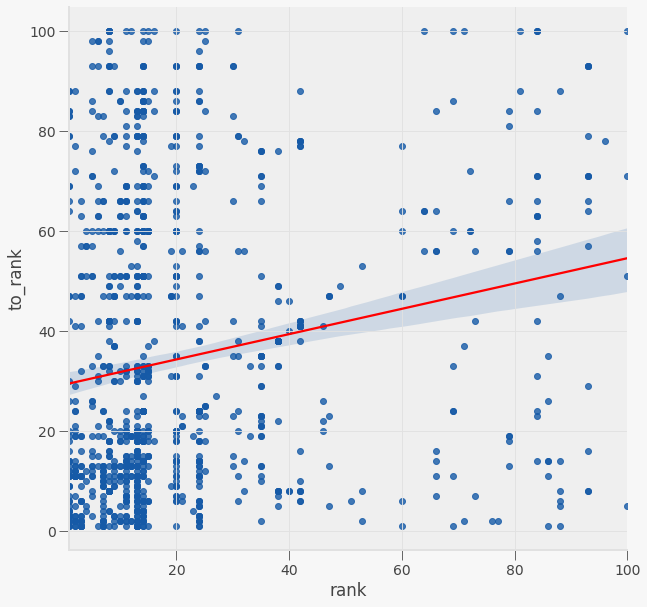

In [17]:
data_clean_rank = inst_data.dropna(subset = ["rank", "to_rank"])
fig, ax = plt.subplots(figsize = (10, 10))
rank_scat = sns.regplot(x = "rank", y = "to_rank", data = data_clean_rank, ax = ax)
rank_scat.get_lines()[0].set_color("red")

In [18]:
skew = pd.DataFrame(data_clean_rank.skew(), columns = ["skewness"])
kurt = pd.DataFrame(data_clean_rank.kurtosis(), columns = ["kurtosis"])
skewkurt = pd.concat([skew, kurt], axis = 1)
fulldesc = pd.concat([data_clean_rank.describe(), skewkurt.T])
fulldesc

,aid,to_institution_id,to_oid,to_latitude,to_longitude,to_rank,recruiter_type,from_oid,from_institution_id,latitude,longitude,category_id,rank,revised_recruiter_hash
count,1210.000000,1210.000000,1210.000000,1124.000000,1124.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1210.000000,1.210000e+03
mean,28022.109091,281.255372,595.200826,39.347232,-45.390382,34.437190,1.450413,333.198347,265.276033,41.339156,-59.320042,9.784298,20.584298,-6.897116e+18
std,14861.038705,279.052782,700.774333,17.295089,67.780175,28.828774,1.088144,323.898202,285.827069,11.168140,49.505632,6.318190,20.640407,4.605921e+18
min,7.000000,2.000000,20.000000,-37.912641,-123.253794,1.000000,1.000000,20.000000,2.000000,-37.801380,-123.250418,1.000000,1.000000,-8.984643e+18
25%,13573.000000,73.000000,139.000000,38.983057,-83.737582,11.000000,1.000000,85.250000,17.000000,39.953339,-83.737582,6.000000,8.000000,-8.984643e+18
50%,33403.000000,184.000000,361.000000,41.789922,-74.655533,24.000000,1.000000,217.000000,186.000000,41.313892,-74.655533,10.000000,14.000000,-8.984643e+18
75%,41955.250000,361.000000,886.000000,47.657111,-1.194493,57.750000,1.000000,406.000000,350.000000,42.376417,-71.083557,13.000000,24.000000,-8.984643e+18
max,47690.000000,1104.000000,5051.000000,59.362174,153.013491,100.000000,8.000000,1347.000000,1089.000000,59.362174,153.013491,34.000000,100.000000,5.398420e+18
skewness,-0.427576,1.229953,2.216633,-3.441758,1.396352,0.711909,3.229377,1.234817,1.066048,-4.929478,1.709218,0.706839,2.060622,2.094046e+00
kurtosis,-1.349272,0.681526,5.764407,12.416536,1.390454,-0.766935,12.683500,0.511837,-0.019915,32.668148,3.831658,0.720395,3.873360,2.782556e+00


Text(0.5, 1.0, 'Correlation Matrix')

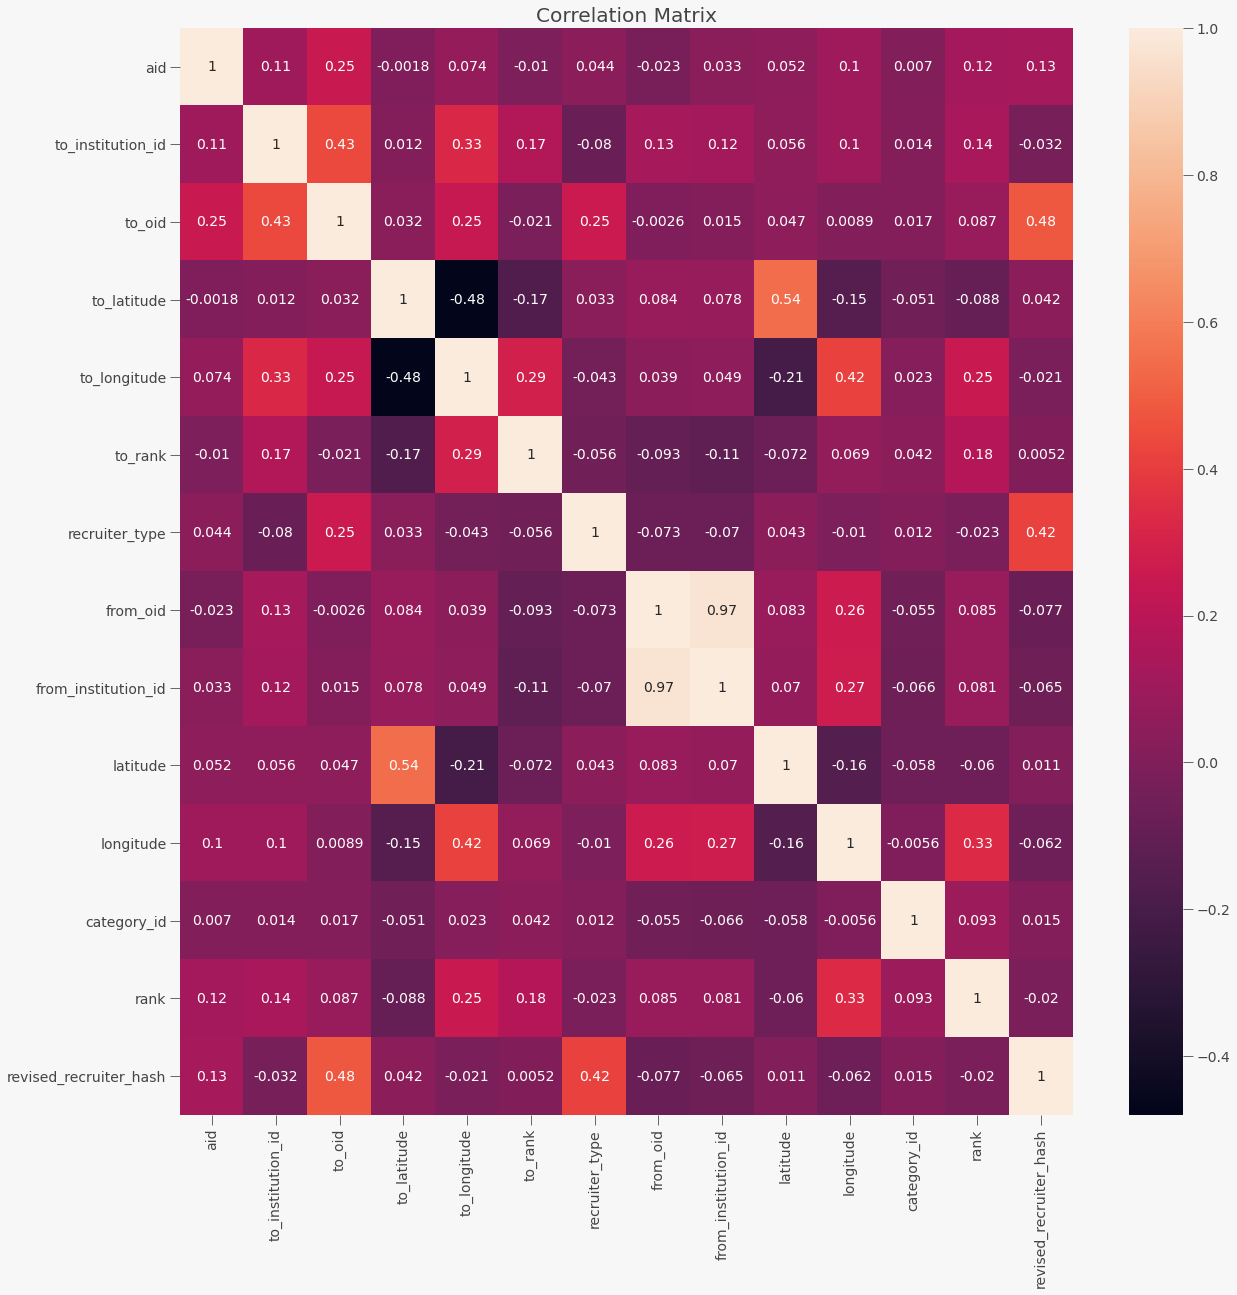

In [19]:
fig, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(data_clean_rank.corr(), annot = True)
ax.set_title("Correlation Matrix")

In [20]:
torank_rank_regression = smf.ols(formula = "to_rank ~ rank", data = data_clean_rank)
torank_rank_regression = torank_rank_regression.fit()
torank_rank_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                to_rank   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     41.14
Date:                Mon, 18 May 2020   Prob (F-statistic):           2.03e-10
Time:                        04:57:19   Log-Likelihood:                -5763.4
No. Observations:                1210   AIC:                         1.153e+04
Df Residuals:                    1208   BIC:                         1.154e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.2196      1.152     25.370      0.000      26.960      31.479
rank           0.2535      0.040      6.414      0.000       0.176       0.331
==============================================================================
Omnibus:                      132.544   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.685
Skew:                           0.722   Prob(JB):                     5.10e-28
Kurtosis:                       2.362   Cond. No.                         41.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
torank_rank_regression_hc1 = smf.ols(formula = "to_rank ~ rank", data = data_clean_rank)
torank_rank_regression_hc1 = torank_rank_regression_hc1.fit(cov_type = "HC1")
torank_rank_regression_hc1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                to_rank   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     35.39
Date:                Mon, 18 May 2020   Prob (F-statistic):           3.54e-09
Time:                        04:57:20   Log-Likelihood:                -5763.4
No. Observations:                1210   AIC:                         1.153e+04
Df Residuals:                    1208   BIC:                         1.154e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.2196      1.179     24.788      0.000      26.909      31.530
rank           0.2535      0.043      5.949      0.000       0.170       0.337
==============================================================================
Omnibus:                      132.544   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.685
Skew:                           0.722   Prob(JB):                     5.10e-28
Kurtosis:                       2.362   Cond. No.                         41.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

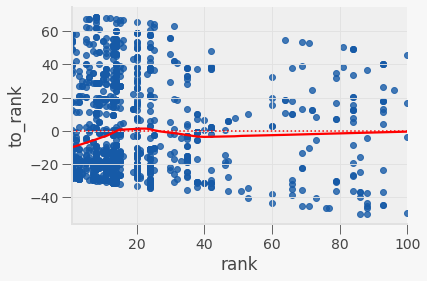

In [22]:
torank_rank_resid = sns.residplot(data_clean_rank["rank"], data_clean_rank["to_rank"], lowess=True)
torank_rank_resid.get_lines()[0].set_color("r")
torank_rank_resid.get_lines()[1].set_color("r")

Text(0.5, 0, 'fitted_values')

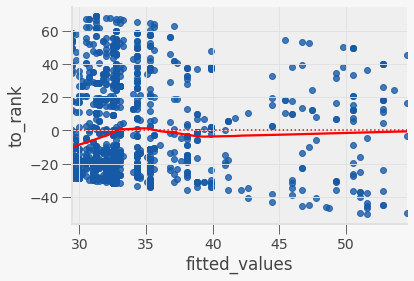

In [23]:
fig, ax = plt.subplots()
fit_resid = sns.residplot(torank_rank_regression_hc1.fittedvalues, data_clean_rank["to_rank"], lowess = True, ax = ax)
fit_resid.get_lines()[0].set_color("r")
fit_resid.get_lines()[1].set_color("r")
ax.set_xlabel("fitted_values")

In [24]:
st.shapiro(torank_rank_regression_hc1.resid) #tests null hypothesis that sample came from normally distributed population; if p value less than alpha, reject null i.e. evidence data tested not normally distributed

(0.9091321229934692, 2.936445048387006e-26)

In [25]:
white_test = het_white(torank_rank_regression_hc1.resid, torank_rank_regression_hc1.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F Statistic", "F-Test p-value"]
whitedict = dict(zip(labels, white_test))
whitedata = pd.DataFrame.from_dict(whitedict, orient = 'index')
whitedata = whitedata.rename(columns = {0 : "White Test Values"})
whitedata

,White Test Values
LM Statistic,5.796547
LM-Test p-value,0.055118
F Statistic,2.905004
F-Test p-value,0.055131


In [26]:
breuschpagan_test = statsmodels.stats.diagnostic.het_breuschpagan(torank_rank_regression_hc1.resid, torank_rank_regression_hc1.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F Statistic", "F-Test p-value"]
breuschpagandict = dict(zip(labels, breuschpagan_test))
breuschpagandata = pd.DataFrame.from_dict(breuschpagandict, orient = 'index')
breuschpagandata = breuschpagandata.rename(columns = {0 : "Breusch-Pagan Test Values"})
breuschpagandata

,Breusch-Pagan Test Values
LM Statistic,1.006099
LM-Test p-value,0.315839
F Statistic,1.005272
F-Test p-value,0.316239


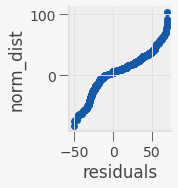

In [27]:
resid_data = pd.DataFrame(torank_rank_regression_hc1.resid)
all_data = pd.concat([data_clean_rank, resid_data], axis = 1)
all_data = all_data.rename(columns = {0: "residuals"})
sqp.qqplot(all_data, x = "residuals", y = st.norm)

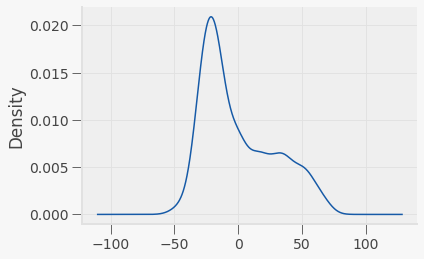

In [28]:
torank_rank_regression_hc1.resid.plot.kde()

In [0]:
#create dummies for recruiter types
data_dummies_rectype = pd.get_dummies(inst_data["revised_description"])

In [0]:
data_with_dummies = pd.concat([inst_data, data_dummies_rectype], axis = 1)

In [0]:
data_with_dummies = data_with_dummies.rename(columns = {"Government agency or commission": "govt", "Academic organization (economics department)": "econ", "Academic organization (agricultural/resource economics department)": "ag_econ", "Academic organization (business school)": "bsns", "Academic organization (other than econ, business, or ag econ)": "ac_othr", "Private business or organization; Other type of organization": "priv"})

In [32]:
data_with_dummies["academia"] = 0

for i in data_with_dummies.index:
    if data_with_dummies.econ[i] == 1 or data_with_dummies.bsns[i] == 1 or data_with_dummies.ac_othr[i] == 1 or data_with_dummies.ag_econ[i] == 1:
      data_with_dummies.academia[i] = 1
    else:
      data_with_dummies.academia[i] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [33]:
from patsy import dmatrices

y_govt, X_rank = dmatrices("govt ~ rank", data_with_dummies, return_type = "dataframe")

govt_regression = sm.Logit(y_govt, X_rank)
govt_regression.fit().summary()

Optimization terminated successfully.
         Current function value: 0.247266
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   govt   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 May 2020   Pseudo R-squ.:                0.001519
Time:                        04:57:28   Log-Likelihood:                -847.38
converged:                       True   LL-Null:                       -848.67
Covariance Type:            nonrobust   LLR p-value:                    0.1084
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7419      0.102    -26.964      0.000      -2.941      -2.543
rank           0.0049      0.003      1.645      0.100      -0.001       0.011
==============================================================================
"""

In [34]:
from patsy import dmatrices

y_econ, X_rank = dmatrices("econ ~ rank", data_with_dummies, return_type = "dataframe")

econ_regression = sm.Logit(y_econ, X_rank)
econ_regression.fit().summary()

Optimization terminated successfully.
         Current function value: 0.675846
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   econ   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 May 2020   Pseudo R-squ.:               0.0002129
Time:                        04:57:29   Log-Likelihood:                -2316.1
converged:                       True   LL-Null:                       -2316.6
Covariance Type:            nonrobust   LLR p-value:                    0.3206
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3355      0.052      6.477      0.000       0.234       0.437
rank           0.0016      0.002      0.991      0.322      -0.002       0.005
==============================================================================
"""

In [35]:
from patsy import dmatrices

y_academia, X_rank = dmatrices("academia ~ rank", data_with_dummies, return_type = "dataframe")

academia_regression = sm.Logit(y_academia, X_rank)
academia_regression.fit().summary()

Optimization terminated successfully.
         Current function value: 0.529936
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               academia   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 May 2020   Pseudo R-squ.:               0.0005607
Time:                        04:57:29   Log-Likelihood:                -1816.1
converged:                       True   LL-Null:                       -1817.1
Covariance Type:            nonrobust   LLR p-value:                    0.1534
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1852      0.061     19.362      0.000       1.065       1.305
rank           0.0028      0.002      1.412      0.158      -0.001       0.007
==============================================================================
"""

In [36]:
from patsy import dmatrices

y_priv, X_rank = dmatrices("priv ~ rank", data_with_dummies, return_type = "dataframe")

priv_regression = sm.Logit(y_econ, X_rank)
priv_regression.fit().summary()

Optimization terminated successfully.
         Current function value: 0.430005
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   priv   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 May 2020   Pseudo R-squ.:                0.002755
Time:                        04:57:30   Log-Likelihood:                -1473.6
converged:                       True   LL-Null:                       -1477.7
Covariance Type:            nonrobust   LLR p-value:                  0.004326
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5449      0.071    -21.869      0.000      -1.683      -1.406
rank          -0.0067      0.002     -2.759      0.006      -0.012      -0.002
==============================================================================
"""

In [0]:
import string 

#create dummies for applicants primary fields
#dummy variable trap
data_dummies_appfie = pd.get_dummies(inst_data["name"], drop_first = True)

#rename columns that may cause issues with regression
foo = pd.Series(data_dummies_appfie.columns.str.lower())

for i in foo.index:
  foo[i] = foo[i].translate(str.maketrans("", "", string.punctuation)) #strips punctutation
  foo[i] = foo[i].replace(" ", "_") #replace space with underscore

appfie_col = pd.Series(data_dummies_appfie.columns)
appfie_dict = pd.concat([foo, appfie_col], axis = 1)
appfie_dict = dict(zip(appfie_dict[1], appfie_dict[0]))

data_dummies_appfie = data_dummies_appfie.rename(columns = appfie_dict)


In [168]:
app_fields_ser = pd.Series(foo)
app_fields_ser.str.cat(sep=" + ")

'any_field + behavioral_economics + business_economics + computational_economics + decision_sciences + development_growth + econometrics + economic_history + environmental_ag_econ + experimental_economics + finance + health_education_welfare + industrial_organization + insurance + international_financemacro + international_trade + labor_demographic_economics + law_and_economics + macroeconomics_monetary + management_general + management_information_technology + marketing + microeconomics + operations_research + organizational_behavior + other + political_economy + public_economics + real_estate + statistics + theory + urban_rural_regional_economics'

In [180]:
data_with_dummies = pd.concat([inst_data, data_dummies_rectype, data_dummies_appfie], axis = 1)
data_with_dummies = data_with_dummies.rename(columns = {"Government agency or commission": "govt", "Academic organization (economics department)": "econ", "Academic organization (agricultural/resource economics department)": "ag_econ", "Academic organization (business school)": "bsns", "Academic organization (other than econ, business, or ag econ)": "ac_othr", "Private business or organization; Other type of organization": "priv"})

data_with_dummies["academia"] = 0

for i in data_with_dummies.index:
    if data_with_dummies.econ[i] == 1 or data_with_dummies.bsns[i] == 1 or data_with_dummies.ac_othr[i] == 1 or data_with_dummies.ag_econ[i] == 1:
      data_with_dummies.academia[i] = 1
    else:
      data_with_dummies.academia[i] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [181]:
from patsy import dmatrices

y_govt, X_rank = dmatrices("govt ~ rank + " + app_fields_ser.str.cat(sep=" + "), data_with_dummies, return_type = "dataframe")

govt_regression = sm.Logit(y_govt, X_rank)
govt_regression.fit().summary()

         Current function value: 0.229502
         Iterations: 35


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   govt   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3393
Method:                           MLE   Df Model:                           33
Date:                Mon, 18 May 2020   Pseudo R-squ.:                 0.07325
Time:                        05:57:27   Log-Likelihood:                -786.50
converged:                      False   LL-Null:                       -848.67
Covariance Type:            nonrobust   LLR p-value:                 1.615e-12
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -20.8852   7224.096     -0.003      0.998   -1.42e+04    1.41e+04
rank                                  0.0057      0.003      1.888      0.059      -0.000       0.012
any_field                            -9.6822   5.47e+05  -1.77e-05      1.000   -1.07e+06    1.07e+06
behavioral_economics                 16.3690   7224.096      0.002      0.998   -1.41e+04    1.42e+04
business_economics                   17.9282   7224.096      0.002      0.998   -1.41e+04    1.42e+04
computational_economics              -2.4888   1.11e+05  -2.24e-05      1.000   -2.18e+05    2.18e+05
decision_sciences                   -24.4522   2.93e+09  -8.33e-09      1.000   -5.75e+09    5.75e+09
development_growth                   17.2906   7224.096      0.002      0.998   -1.41e+04    1.42e+04
econometrics                         17.1425   7224.096      0.002      0.998   -1.41e+04    1.42e+04
economic_history                     16.9633   7224.096      0.002      0.998   -1.41e+04    1.42e+04
environmental_ag_econ                17.8583   7224.096      0.002      0.998   -1.41e+04    1.42e+04
experimental_economics               16.6242   7224.096      0.002      0.998   -1.41e+04    1.42e+04
finance                              18.4443   7224.096      0.003      0.998   -1.41e+04    1.42e+04
health_education_welfare             17.8483   7224.096      0.002      0.998   -1.41e+04    1.42e+04
industrial_organization              18.3821   7224.096      0.003      0.998   -1.41e+04    1.42e+04
insurance                           -10.0673   3.35e+06     -3e-06      1.000   -6.57e+06    6.57e+06
international_financemacro           18.6616   7224.096      0.003      0.998   -1.41e+04    1.42e+04
international_trade                  17.5066   7224.096      0.002      0.998   -1.41e+04    1.42e+04
labor_demographic_economics          18.0323   7224.096      0.002      0.998   -1.41e+04    1.42e+04
law_and_economics                    19.6331   7224.096      0.003      0.998   -1.41e+04    1.42e+04
macroeconomics_monetary              19.0929   7224.096      0.003      0.998   -1.41e+04    1.42e+04
management_general                   -6.8975   2.49e+05  -2.77e-05      1.000   -4.89e+05    4.89e+05
management_information_technology    -2.4313   1.11e+05  -2.18e-05      1.000   -2.18e+05    2.18e+05
marketing                            -1.1562    3.3e+04  -3.51e-05      1.000   -6.46e+04    6.46e+04
microeconomics                       17.7134   7224.096      0.002      0.998   -1.41e+04    1.42e+04
operations_research                   3.5397   7894.753      0.000      1.000   -1.55e+04    1.55e+04
organizational_behavior              -9.9427   3.36e+06  -2.96e-06      1.000   -6.58e+06    6.58e+06
other                               -24.3559   2.81e+09  -8.66e-09      1.000   -5.51e+09    5.51e+09
political_economy                    16.6877   7224.096      0.002      0.998  

In [182]:
from patsy import dmatrices

y_econ, X_rank = dmatrices("econ ~ rank + " + app_fields_ser.str.cat(sep=" + "), data_with_dummies, return_type = "dataframe")

econ_regression = sm.Logit(y_econ, X_rank)
econ_regression.fit().summary()

         Current function value: 0.653948
         Iterations: 35


LinAlgError: ignored

In [183]:
from patsy import dmatrices

y_academia, X_rank = dmatrices("academia ~ rank + " + app_fields_ser.str.cat(sep=" + "), data_with_dummies, return_type = "dataframe")

academia_regression = sm.Logit(y_academia, X_rank)
academia_regression.fit().summary()

         Current function value: 0.508113
         Iterations: 35


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               academia   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3393
Method:                           MLE   Df Model:                           33
Date:                Mon, 18 May 2020   Pseudo R-squ.:                 0.04172
Time:                        05:57:27   Log-Likelihood:                -1741.3
converged:                      False   LL-Null:                       -1817.1
Covariance Type:            nonrobust   LLR p-value:                 3.938e-17
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             2.8182      1.029      2.739      0.006       0.802       4.835
rank                                  0.0027      0.002      1.302      0.193      -0.001       0.007
any_field                            -1.2262      1.097     -1.117      0.264      -3.377       0.925
behavioral_economics                 -0.7250      1.093     -0.663      0.507      -2.868       1.418
business_economics                   -0.7933      1.272     -0.624      0.533      -3.287       1.700
computational_economics              14.5577   6124.206      0.002      0.998    -1.2e+04     1.2e+04
decision_sciences                    12.3309    896.964      0.014      0.989   -1745.686    1770.348
development_growth                   -1.6367      1.037     -1.579      0.114      -3.669       0.395
econometrics                         -0.8228      1.049     -0.784      0.433      -2.879       1.234
economic_history                     -0.9380      1.117     -0.840      0.401      -3.127       1.251
environmental_ag_econ                -1.7680      1.045     -1.692      0.091      -3.816       0.280
experimental_economics               -0.6749      1.114     -0.606      0.545      -2.858       1.508
finance                              -1.6143      1.036     -1.558      0.119      -3.645       0.416
health_education_welfare             -1.8799      1.046     -1.797      0.072      -3.931       0.171
industrial_organization              -1.7837      1.040     -1.715      0.086      -3.822       0.254
insurance                            16.9496   1.46e+04      0.001      0.999   -2.85e+04    2.86e+04
international_financemacro           -2.3352      1.043     -2.239      0.025      -4.380      -0.291
international_trade                  -1.0964      1.049     -1.045      0.296      -3.153       0.960
labor_demographic_economics          -1.6599      1.035     -1.604      0.109      -3.688       0.369
law_and_economics                    -1.7891      1.225     -1.461      0.144      -4.190       0.612
macroeconomics_monetary              -2.3340      1.033     -2.260      0.024      -4.358      -0.310
management_general                   -0.1793      1.457     -0.123      0.902      -3.035       2.676
management_information_technology    14.5844   6124.214      0.002      0.998    -1.2e+04     1.2e+04
marketing                            15.7923   6624.652      0.002      0.998    -1.3e+04     1.3e+04
microeconomics                       -1.3626      1.040     -1.310      0.190      -3.401       0.676
operations_research                  16.6963   1.02e+04      0.002      0.999   -2.01e+04    2.01e+04
organizational_behavior              14.5956   4354.455      0.003      0.997   -8519.979    8549.170
other                                -1.4851      1.519     -0.978      0.328      -4.461       1.491
political_economy                    -0.9732      1.095     -0.888      0.374  

In [184]:
from patsy import dmatrices

y_priv, X_rank = dmatrices("priv ~ rank + " + app_fields_ser.str.cat(sep=" + "), data_with_dummies, return_type = "dataframe")

priv_regression = sm.Logit(y_priv, X_rank)
priv_regression.fit().summary()

         Current function value: 0.419118
         Iterations: 35


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   priv   No. Observations:                 3427
Model:                          Logit   Df Residuals:                     3393
Method:                           MLE   Df Model:                           33
Date:                Mon, 18 May 2020   Pseudo R-squ.:                 0.02800
Time:                        06:00:06   Log-Likelihood:                -1436.3
converged:                      False   LL-Null:                       -1477.7
Covariance Type:            nonrobust   LLR p-value:                 3.700e-06
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -2.7114      1.030     -2.633      0.008      -4.730      -0.693
rank                                 -0.0069      0.002     -2.770      0.006      -0.012      -0.002
any_field                             1.2534      1.098      1.141      0.254      -0.899       3.406
behavioral_economics                  0.5857      1.102      0.532      0.595      -1.574       2.745
business_economics                    0.0148      1.455      0.010      0.992      -2.837       2.866
computational_economics             -14.5630   6124.200     -0.002      0.998    -1.2e+04     1.2e+04
decision_sciences                   -18.1003   1.59e+04     -0.001      0.999   -3.12e+04    3.12e+04
development_growth                    1.4260      1.038      1.373      0.170      -0.609       3.461
econometrics                          0.5148      1.056      0.488      0.626      -1.554       2.584
economic_history                      0.6887      1.132      0.608      0.543      -1.530       2.907
environmental_ag_econ                 1.4502      1.049      1.383      0.167      -0.605       3.506
experimental_economics                0.4767      1.129      0.422      0.673      -1.736       2.690
finance                               0.9554      1.041      0.918      0.359      -1.085       2.996
health_education_welfare              1.5863      1.050      1.511      0.131      -0.472       3.644
industrial_organization               1.2393      1.045      1.186      0.236      -0.809       3.288
insurance                            -7.5376    134.766     -0.056      0.955    -271.674     256.599
international_financemacro            1.8038      1.047      1.723      0.085      -0.248       3.856
international_trade                   0.7379      1.056      0.699      0.485      -1.332       2.808
labor_demographic_economics           1.2493      1.037      1.204      0.229      -0.784       3.283
law_and_economics                   -25.1120   3.47e+05  -7.24e-05      1.000    -6.8e+05     6.8e+05
macroeconomics_monetary               1.5148      1.035      1.463      0.143      -0.514       3.544
management_general                    0.1776      1.458      0.122      0.903      -2.679       3.034
management_information_technology   -14.6320   6124.231     -0.002      0.998    -1.2e+04     1.2e+04
marketing                           -17.7260   1.77e+04     -0.001      0.999   -3.46e+04    3.46e+04
microeconomics                        0.9965      1.044      0.955      0.340      -1.050       3.043
operations_research                 -16.7191   1.02e+04     -0.002      0.999   -2.01e+04    2.01e+04
organizational_behavior             -21.2818    1.2e+05     -0.000      1.000   -2.36e+05    2.36e+05
other                                 1.4616      1.519      0.962      0.336      -1.516       4.439
political_economy                     0.7845      1.104      0.711      0.477  